In [7]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


import keras_tuner
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

## Data loading and preprocessing

In [8]:
datapath = r'/Users/ignacioaranguren/QR_assignment/'
os.chdir(datapath)

In [3]:
columns=['Matching Time', 'Receiving Time', 'Symbol']
for i in range(1,11):
    columns += [f'BID_PRICE{i}', f'BID_QTY_{i}', f'ASK_PRICE_{i}', f'ASK_QTY_{i}']

In [4]:
df_train_tmp = pd.read_csv(f'data/exchange1_20210519.csv', names=columns).set_index('Matching Time').append(pd.read_csv(f'data/exchange1_20210520.csv', names=columns).set_index('Matching Time'))
df_test_tmp = pd.read_csv(f'data/exchange1_20210521.csv', names=columns).set_index('Matching Time')

In [5]:
scaler = MinMaxScaler()
scaler.fit(df_train_tmp[df_train_tmp.columns[2:]])
df_train_tmp[df_train_tmp.columns[2:]] = scaler.fit_transform(df_train_tmp[df_train_tmp.columns[2:]])
scaler = MinMaxScaler()
scaler.fit(df_test_tmp[df_test_tmp.columns[2:]])
df_test_tmp[df_test_tmp.columns[2:]] = scaler.fit_transform(df_test_tmp[df_test_tmp.columns[2:]])

In [6]:
df_train_tmp['MID_PRICE'] = (df_train_tmp['BID_PRICE1'] + df_train_tmp['ASK_PRICE_1']) / 2
df_test_tmp['MID_PRICE'] = (df_test_tmp['BID_PRICE1'] + df_test_tmp['ASK_PRICE_1']) / 2

In [7]:
def mid_price_trend(df, k, alpha):
    # Contiguous mid values may be noisy. We need to smooth them by calculating the mean to infere the price trend
    trend = []
    for i in tqdm(range(k//2, len(df['MID_PRICE']) - k//2)):
        prev_k_mid_prices = df.iloc[i - k//2: i, -1].mean()
        next_k_mid_prices = df.iloc[i: i + k//2, -1].mean()
        if prev_k_mid_prices < next_k_mid_prices * (1 + alpha):
            trend += [1]
        elif prev_k_mid_prices > next_k_mid_prices * (1 - alpha):
            trend += [-1]
        else:
            trend += [0]
    return trend

In [8]:
K_HORIZON = 20
ALPHA = 0

In [9]:
trend_train = mid_price_trend(df_train_tmp, K_HORIZON, ALPHA)
df_train_tmp['TREND_MID_PRICE'] = pd.Series(trend_train, index=df_train_tmp.index[K_HORIZON//2:-K_HORIZON//2]) 
df_train_tmp = df_train_tmp.dropna()

100%|██████████████████████████████████████████████████████████████████████████| 4523864/4523864 [18:55<00:00, 3984.91it/s]


In [10]:
trend_test = mid_price_trend(df_test_tmp, K_HORIZON, ALPHA)
df_test_tmp['TREND_MID_PRICE'] = pd.Series(data=trend_test, index=df_test_tmp.index[K_HORIZON//2:-K_HORIZON//2]) 
df_test_tmp = df_test_tmp.dropna()

100%|██████████████████████████████████████████████████████████████████████████| 2403150/2403150 [10:12<00:00, 3926.26it/s]


In [11]:
with open('data/trend_train_k_20.pkl','wb') as f:
    pickle.dump(trend_train,f)
with open('data/trend_test_k_20.pkl','wb') as f:
    pickle.dump(trend_test,f)

In [12]:
df_train_tmp.describe()

,BID_PRICE1,BID_QTY_1,ASK_PRICE_1,ASK_QTY_1,BID_PRICE2,BID_QTY_2,ASK_PRICE_2,ASK_QTY_2,BID_PRICE3,BID_QTY_3,...,BID_PRICE9,BID_QTY_9,ASK_PRICE_9,ASK_QTY_9,BID_PRICE10,BID_QTY_10,ASK_PRICE_10,ASK_QTY_10,MID_PRICE,TREND_MID_PRICE
count,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,...,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06,4.523864e+06
mean,7.243831e-01,1.708136e-03,7.225780e-01,2.263191e-03,7.243022e-01,1.370084e-03,7.222462e-01,1.767895e-03,7.243999e-01,1.441995e-03,...,7.257788e-01,1.743585e-03,7.198853e-01,2.438933e-03,7.262230e-01,1.812457e-03,7.181023e-01,2.516551e-03,7.234805e-01,-1.078834e-02
std,1.084827e-01,8.157408e-03,1.089586e-01,1.121440e-02,1.085240e-01,6.038045e-03,1.090480e-01,8.447833e-03,1.085274e-01,5.931701e-03,...,1.082640e-01,5.877173e-03,1.097558e-01,9.015122e-03,1.081734e-01,5.896087e-03,1.104199e-01,8.948883e-03,1.087204e-01,9.316808e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00
25%,6.800523e-01,6.071431e-05,6.780306e-01,8.796284e-05,6.800027e-01,5.025966e-05,6.776093e-01,7.311911e-05,6.801567e-01,6.360354e-05,...,6.817964e-01,6.907378e-05,6.747114e-01,1.072070e-04,6.822774e-01,7.070571e-05,6.726517e-01,1.073899e-04,6.790756e-01,-1.000000e+00
50%,7.347177e-01,2.203098e-04,7.329369e-01,3.210644e-04,7.346532e-01,1.598484e-04,7.325992e-01,2.334680e-04,7.347808e-01,1.709266e-04,...,7.361405e-01,3.636972e-04,7.301854e-01,5.669529e-04,7.366193e-01,3.989199e-04,7.284889e-01,6.461689e-04,7.338271e-01,0.000000e+00
75%,7.825070e-01,7.303351e-04,7.809972e-01,1.050973e-03,7.824294e-01,5.180902e-04,7.807327e-01,7.509827e-04,7.825340e-01,6.248188e-04,...,7.837173e-01,1.276992e-03,7.788038e-01,1.984609e-03,7.841344e-01,1.401519e-03,7.773553e-01,2.195181e-03,7.817519e-01,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [13]:
df_test_tmp.describe()

,BID_PRICE1,BID_QTY_1,ASK_PRICE_1,ASK_QTY_1,BID_PRICE2,BID_QTY_2,ASK_PRICE_2,ASK_QTY_2,BID_PRICE3,BID_QTY_3,...,BID_PRICE9,BID_QTY_9,ASK_PRICE_9,ASK_QTY_9,BID_PRICE10,BID_QTY_10,ASK_PRICE_10,ASK_QTY_10,MID_PRICE,TREND_MID_PRICE
count,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,...,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06,2.403150e+06
mean,6.368382e-01,3.321310e-03,6.356375e-01,2.428604e-03,6.378413e-01,2.005472e-03,6.347423e-01,1.648559e-03,6.380259e-01,2.251894e-03,...,6.381818e-01,3.580512e-03,6.317899e-01,2.818728e-03,6.384726e-01,3.810461e-03,6.317734e-01,2.985486e-03,6.362378e-01,-9.249943e-03
std,2.297077e-01,1.607249e-02,2.296686e-01,1.684914e-02,2.296838e-01,9.945955e-03,2.294845e-01,1.240778e-02,2.295771e-01,1.059624e-02,...,2.298244e-01,1.240951e-02,2.285868e-01,1.293692e-02,2.298410e-01,1.273617e-02,2.285434e-01,1.261898e-02,2.296881e-01,9.042742e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.804393e-04,-1.000000e+00
25%,4.042867e-01,2.088198e-04,4.030849e-01,1.509219e-04,4.053288e-01,1.272300e-04,4.024708e-01,1.144943e-04,4.056657e-01,1.515221e-04,...,4.055556e-01,1.543044e-04,4.002485e-01,1.337446e-04,4.058957e-01,1.561917e-04,4.003163e-01,1.345886e-04,4.036858e-01,-1.000000e+00
50%,7.273758e-01,7.181528e-04,7.262107e-01,5.062537e-04,7.284580e-01,3.953544e-04,7.251502e-01,3.587667e-04,7.286119e-01,4.141808e-04,...,7.289116e-01,9.728148e-04,7.218708e-01,8.520520e-04,7.292517e-01,1.063620e-03,7.217892e-01,9.193313e-04,7.267933e-01,0.000000e+00
75%,8.347698e-01,2.228750e-03,8.335035e-01,1.508968e-03,8.357143e-01,1.211874e-03,8.325966e-01,1.022137e-03,8.358074e-01,1.350642e-03,...,8.362812e-01,3.030308e-03,8.287393e-01,2.612441e-03,8.366213e-01,3.147187e-03,8.287586e-01,2.714561e-03,8.340799e-01,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [14]:
df_test_tmp.to_csv('data/sets/test_set_k_20.csv',columns=list(df_test_tmp.columns.values))
df_train_tmp.to_csv('data/sets/train_set_k_20.csv',columns=list(df_train_tmp.columns.values))

## Set balancing

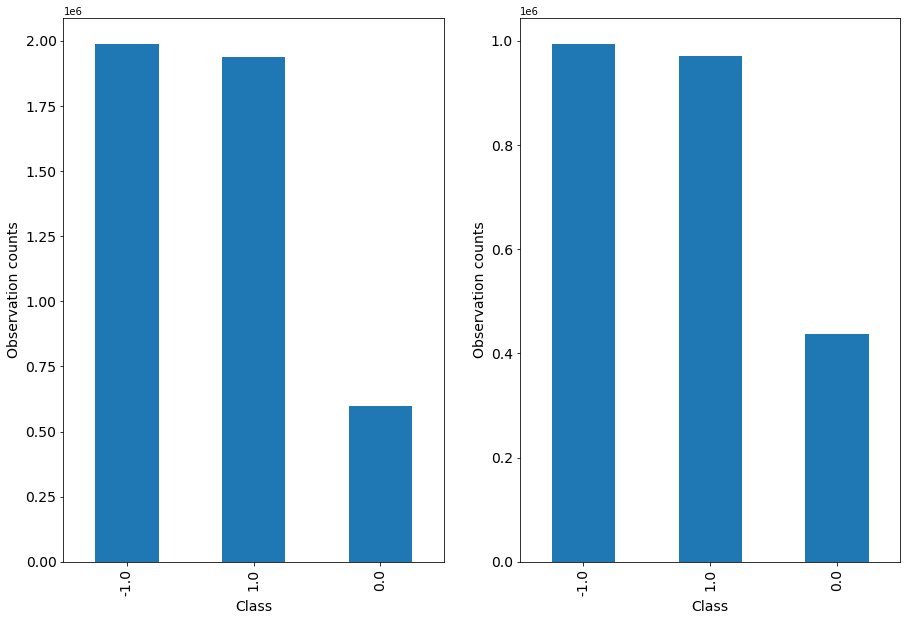

In [15]:
fig, (ax_train, ax_test) = plt.subplots(figsize=(15,10), ncols = 2)
df_train_tmp['TREND_MID_PRICE'].value_counts().plot(kind='bar', ax=ax_train, fontsize=14)
df_test_tmp['TREND_MID_PRICE'].value_counts().plot(kind='bar', ax=ax_test, fontsize=14)
ax_train.set_ylabel('Observation counts', fontsize=14)
ax_train.set_xlabel('Class', fontsize=14)
ax_test.set_ylabel('Observation counts', fontsize=14)
ax_test.set_xlabel('Class', fontsize=14)
plt.show()

## CNN with LSTM

References: 

[1] Zhang, Z., Zohren, S. and Roberts, S. (2018) DeepLOB: Deep Convolutional Neural Networks for Limit Order Books. 
<br>
[2] Iosifidis, A. et al. (2017) Forecasting Stock Prices from the Limit Order Book using Convolutional Neural Networks. 

CNN model:
https://github.com/zcakhaa/DeepLOB-Deep-Convolutional-Neural-Networks-for-Limit-Order-Books

### DATA PREPARATION

In [1]:
import os
datapath = r'/Users/ignacioaranguren/QR_assignment/'
os.chdir(datapath)

In [2]:
# Load only the necessary modules to optimize memory usage
from tqdm import tqdm
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

In [3]:
df_train_tmp = pd.read_csv(f'data/sets/train_set_k_20.csv').set_index('Matching Time')
df_test = pd.read_csv(f'data/sets/test_set_k_20.csv').set_index('Matching Time')

In [4]:
def train_validation_split(data, train_end_index):
    tmp = data.reset_index()
    train = tmp.iloc[:train_end_index].set_index(['Matching Time'],drop=True)
    validation = tmp[train_end_index:].set_index(['Matching Time'],drop=True)
    return train, validation

We use a reduced training and tests datasets since the data processing has to be carried out in matrixes of 100 x 40 

In [5]:
# Need to reduce the orgininal train set. My computer can't handle the processing with full size
df_train_tmp_reduced = df_train_tmp.iloc[:int(len(df_train_tmp)*0.8)]
df_test = df_test[:int(len(df_test)*0.7)]

In [6]:
train_to_val_ratio = 0.8
train_index = int(len(df_train_tmp_reduced) * train_to_val_ratio)
df_train, df_val = train_validation_split(df_train_tmp_reduced, train_index)

In [7]:
def data_classification(X, n_input):
    [N, D] = X.shape # returns the dimension of the set. N_Observations x 40 
    dataX = np.zeros((N - n_input + 1, n_input, D)) # Create N-H + 1 matrixes of n_input x 40 dimension
    for i in tqdm(range(n_input, N + 1)):
        dataX[i - n_input] = X[i - n_input:i, :]
    return dataX.reshape(dataX.shape + (1,))

The original paper used a depth of 100 in the LOB. Due to limitations in computational power, I am using a depth of 20 in my model. 

In [8]:
n_input = 20

def prepare_x_y(data, n_input):
    x = np.array(data.iloc[:, 2:-2])
    y = data.iloc[:, -1:].values
    y = y[n_input -1:]
    x = data_classification(x, n_input)
    y = to_categorical(y, 3)
    return x, y

In [9]:
X_train_CNN, y_train_CNN = prepare_x_y(df_train, n_input)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2895253/2895253 [00:17<00:00, 161067.35it/s]


In [10]:
X_val_CNN, y_val_CNN = prepare_x_y(df_val, n_input)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 723800/723800 [00:03<00:00, 219822.88it/s]


In [11]:
X_test_CNN, y_test_CNN = prepare_x_y(df_test, n_input)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1682186/1682186 [00:08<00:00, 204284.85it/s]


We can see the results. This will be the training, val and test sets that will be used to fit, validate and test the model. 

### Model definition

We create the model described by Zhang (2018) adapted to peform hyperparameter selection. The hyperparameters to be tested are:

- Learning rate: Used in order to control the step's size in gradient descent. 
- Dropout rate: Parameter used to control overfitting. It randomly drops units in the NN accordingly to the rate specified.
- Alpha rate: Avoids "Dying ReLu" problem.

In [12]:
from tensorflow.keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, concatenate
from keras.models import load_model, Model
from keras_tuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

import keras_tuner
import pickle

In [13]:
def keras_model_CNN(n_observation, n_predictors, n_layers, dropout_rate, learning_rate, alpha_rate):
    input_lmd = Input(shape=(n_observation, n_predictors, 1))
    
    # Build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = LeakyReLU(alpha=alpha_rate)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = LeakyReLU(alpha=alpha_rate)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = LeakyReLU(alpha=alpha_rate)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = LeakyReLU(alpha=alpha_rate)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = LeakyReLU(alpha=alpha_rate)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = Dropout(rate=dropout_rate, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # Build the last LSTM layer
    conv_lstm = LSTM(n_layers)(conv_reshape)

    # Build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

class HyperRegressorCNN(keras_tuner.HyperModel):
    def __init__(self, n_layers, n_observation, n_predictors, *args, **kwargs):
        # Pass all arguments except number of layers, n_observation and n_predictors to parent
        self.n_layers = n_layers
        self.n_observation = n_observation
        self.n_predictors = n_predictors
        super().__init__(*args, **kwargs)

    def build(self, hp):
        # Hyperparameters choices and ranges definition 
        learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, default=0.25, step=0.1)
        alpha_rate = hp.Float("alpha_rate", min_value=1e-4, max_value=1e-1, sampling="log")
        return keras_model_CNN(
            self.n_observation, 
            self.n_predictors,
            self.n_layers,
            dropout_rate, 
            learning_rate, 
            alpha_rate
        )
    
    def fit(self, hp, model, x, y, validation_data, **kwargs):
        model.fit(x, y, **kwargs)
        x_val, y_val = validation_data
        y_pred = model.predict(x_val)
        # Return a single float to minimize.
        return -np.sum(y_val * np.log(y_pred)) # Categorical cross entropy loss


In [14]:
########################
# CONSTANTS DEFINITION #
########################

MAX_TRIALS = 3
EXECUTION_PER_TRIAL = 1
EPOCHS = 3
BATCH_SIZE = 1024

n_observation = X_train_CNN.shape[1]
n_predictors = X_train_CNN.shape[2]
n_layers = 64

def tune_model():
    # Early stop if loss does not improve after 3 epochs
    callback = EarlyStopping(monitor='loss', patience=3)
    tuner = RandomSearch(
        hypermodel=HyperRegressorCNN(n_layers, n_observation, n_predictors),
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTION_PER_TRIAL,
        overwrite=True,
        directory='IA_QR',
        project_name='CNN'
    )
    tuner.search(
      X_train_CNN, 
      y_train_CNN,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(X_val_CNN, y_val_CNN),
      callbacks=[callback]
    )
    return tuner

In [24]:
tuner_CNN = tune_model()

Trial 3 Complete [01h 36m 44s]
default_objective: 429206.09375

Best default_objective So Far: 429206.09375
Total elapsed time: 04h 49m 54s
INFO:tensorflow:Oracle triggered exit


In [25]:
with open('models/cnn/tuner_CNN_k_20.pkl','wb') as f:
    pickle.dump(tuner_CNN,f)

In [15]:
with open('models/cnn/tuner_CNN_k_20.pkl','rb') as f:
    tuner_CNN = pickle.load(f)

In [17]:
best_hps_CNN = tuner_CNN.get_best_hyperparameters()[0].values
print(best_hps_CNN)
CNN_model = keras_model_CNN(n_observation, n_predictors, n_layers, **best_hps_CNN) # Rebuild model

{'learning_rate': 0.002907250525972576, 'dropout_rate': 0.2, 'alpha_rate': 0.004047281713314244}


2022-06-09 22:21:40.456933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
callback = EarlyStopping(monitor='loss', patience=3)
CNN_model.fit(X_train_CNN, y_train_CNN, validation_data=(X_val_CNN, y_val_CNN), 
            epochs=12, batch_size=1024, verbose=1, callbacks=callback)

Epoch 1/12
2828/2828 [==============================] - 1946s 687ms/step - loss: 0.7734 - accuracy: 0.6046 - val_loss: 0.7245 - val_accuracy: 0.6629
Epoch 2/12
2828/2828 [==============================] - 1936s 685ms/step - loss: 0.5904 - accuracy: 0.7322 - val_loss: 0.6177 - val_accuracy: 0.7226
Epoch 3/12
2828/2828 [==============================] - 1934s 684ms/step - loss: 0.5622 - accuracy: 0.7470 - val_loss: 0.6024 - val_accuracy: 0.7294
Epoch 4/12
2828/2828 [==============================] - 1927s 681ms/step - loss: 0.5456 - accuracy: 0.7554 - val_loss: 0.5912 - val_accuracy: 0.7355
Epoch 5/12
2828/2828 [==============================] - 1931s 683ms/step - loss: 0.5341 - accuracy: 0.7611 - val_loss: 0.5821 - val_accuracy: 0.7409
Epoch 6/12
2828/2828 [==============================] - 1924s 680ms/step - loss: 0.5267 - accuracy: 0.7646 - val_loss: 0.5733 - val_accuracy: 0.7448
Epoch 7/12
2828/2828 [==============================] - 1926s 681ms/step - loss: 0.5206 - accuracy: 0.7678

In [19]:
with open('models/cnn/tuner_CNN_refitted_k_20.pkl','wb') as f:
    pickle.dump(CNN_model,f)

INFO:tensorflow:Assets written to: ram://d7e46b77-9649-4c19-8b5a-0aeee480b67c/assets


INFO:tensorflow:Assets written to: ram://d7e46b77-9649-4c19-8b5a-0aeee480b67c/assets


In [20]:
labels = ['STATIONARY', 'POSITIVE', 'NEGATIVE']
y_pred_CNN = CNN_model.predict(X_test_CNN)

52569/52569 [==============================] - 316s 6ms/step


In [21]:
print('accuracy_score:', accuracy_score(np.argmax(y_test_CNN, axis=1), np.argmax(y_pred_CNN, axis=1)))
print(classification_report(np.argmax(y_test_CNN, axis=1), np.argmax(y_pred_CNN, axis=1), digits=4, target_names=labels))

accuracy_score: 0.7675441360230082
              precision    recall  f1-score   support

  STATIONARY     0.6562    0.7655    0.7066    332725
    POSITIVE     0.7756    0.7948    0.7851    664499
    NEGATIVE     0.8291    0.7421    0.7832    684962

    accuracy                         0.7675   1682186
   macro avg     0.7536    0.7675    0.7583   1682186
weighted avg     0.7738    0.7675    0.7688   1682186



That's a huge increase in the performance on the stationary class. 